In [1]:
%run base.ipynb
%matplotlib inline

import Transient as transient
import matplotlib.pyplot as plt
import numpy as np
import siglayer.examples as examples
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torchdata
import torchvision.transforms as transforms

import utils

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Hyperparameters

In [2]:
train_batch_size = 128
val_batch_size = 128
max_epochs = 5

optimizer_fn = optim.Adam
loss_fn = F.binary_cross_entropy

num_peaks = 4

sig_depth = 3
num_hidden_windows = 0

In [3]:
# we can't always deduce this from the example y that we sample below - check out the MNIST example; there the
# loss function expects a network which produces one-hot encoded values, but with labels that are integers, so the
# shapes don't agree
output_shape = (num_peaks,)

## Data

In [4]:
train_dataset = transient.get(train=True, num_peaks=num_peaks)
eval_dataset = transient.get(train=False, num_peaks=num_peaks)
    
train_dataloader = torchdata.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=8)
eval_dataloader = torchdata.DataLoader(eval_dataset, batch_size=val_batch_size, shuffle=False, num_workers=8)

Feature shape: (1, 100)
Label shape: (4,)
Example element:


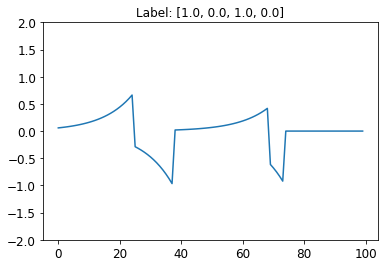

In [5]:
example_batch_x, example_batch_y = next(iter(train_dataloader))
example_x, example_y = example_batch_x[0], example_batch_y[0]

assert example_y.shape == output_shape

print(f'Feature shape: {tuple(example_x.shape)}')
print(f'Label shape: {tuple(example_y.shape)}')
print('Example element:')
plt.plot(example_x.numpy().squeeze())
plt.title(f'Label: {list(example_y.numpy())}')
plt.ylim(-2, 2)
plt.show()

## Networks: SigNet and ReluNet

In [6]:
signet = examples.create_windowed(output_shape, sig=True, sig_depth=sig_depth, final_nonlinearity=torch.sigmoid, 
                                  num_hidden_windows=num_hidden_windows)
relunet = examples.create_windowed(output_shape, sig=False, final_nonlinearity=torch.sigmoid, 
                                   num_hidden_windows=num_hidden_windows)

## Train Model

In [7]:
history = {}
train_model = utils.create_train_model_fn(max_epochs, optimizer_fn, loss_fn, train_dataloader, eval_dataloader, 
                                          example_batch_x)

In [8]:
train_model(relunet, 'ReluNet', history)

TrainAcc: 0.50 TrainLoss: 0.69 ValAcc: 0.50 ValLoss: 0.69
Epoch:    1 Loss: 0.075: 100%|██████████| 391/391 [00:07<00:00, 58.31it/s]
TrainAcc: 0.98 TrainLoss: 0.06 ValAcc: 0.98 ValLoss: 0.06
Epoch:    2 Loss: 0.008: 100%|██████████| 391/391 [00:07<00:00, 57.09it/s]
TrainAcc: 1.00 TrainLoss: 0.01 ValAcc: 1.00 ValLoss: 0.01
Epoch:    3 Loss: 0.001: 100%|██████████| 391/391 [00:07<00:00, 57.03it/s]
TrainAcc: 1.00 TrainLoss: 0.00 ValAcc: 1.00 ValLoss: 0.00
Epoch:    4 Loss: 0.001: 100%|██████████| 391/391 [00:06<00:00, 59.41it/s]
TrainAcc: 1.00 TrainLoss: 0.00 ValAcc: 1.00 ValLoss: 0.00
Epoch:    5 Loss: 0.000: 100%|██████████| 391/391 [00:07<00:00, 56.15it/s]
TrainAcc: 1.00 TrainLoss: 0.00 ValAcc: 1.00 ValLoss: 0.00
Training took 60.52 seconds.


In [9]:
train_model(signet, 'SigNet', history)

TrainAcc: 0.50 TrainLoss: 0.69 ValAcc: 0.50 ValLoss: 0.70
Epoch:    1 Loss: 0.183: 100%|██████████| 391/391 [02:32<00:00,  2.60it/s]
TrainAcc: 0.89 TrainLoss: 0.21 ValAcc: 0.89 ValLoss: 0.21
Epoch:    2 Loss: 0.049: 100%|██████████| 391/391 [02:31<00:00,  2.65it/s]
TrainAcc: 0.99 TrainLoss: 0.03 ValAcc: 0.99 ValLoss: 0.04
Epoch:    3 Loss: 0.015: 100%|██████████| 391/391 [02:32<00:00,  2.57it/s]
TrainAcc: 1.00 TrainLoss: 0.02 ValAcc: 1.00 ValLoss: 0.02
Epoch:    4 Loss: 0.006: 100%|██████████| 391/391 [02:31<00:00,  2.62it/s]
TrainAcc: 1.00 TrainLoss: 0.01 ValAcc: 1.00 ValLoss: 0.01
Epoch:    5 Loss: 0.004: 100%|██████████| 391/391 [02:31<00:00,  2.59it/s]
TrainAcc: 1.00 TrainLoss: 0.00 ValAcc: 1.00 ValLoss: 0.01
Training took 1147.63 seconds.


## Results

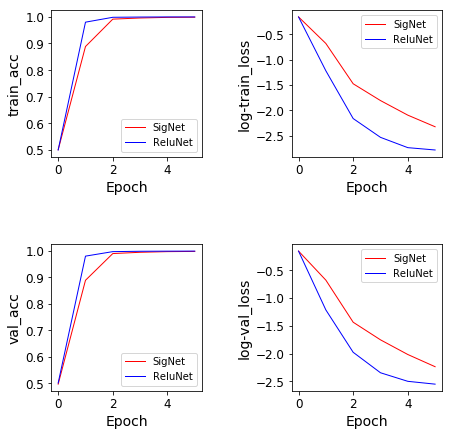

SigNet parameter count: 5838
ReluNet parameter count: 5710


In [10]:
utils.print_results(signet, relunet, history)